In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
import goes2go.data 


In [6]:
# Get latest data
#G1 = goes2go.data.goes_latest(satellite='G16', product='ABI')

# Get data for a specific time
G2 = goes2go.data.goes_nearesttime(datetime.datetime(2021,6,27), satellite='G16', product='ABI')


 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-MCMIPC    |
 |    Domain: C                |
📦 Finished downloading [1] files to [/home/sfreeman/data/noaa-goes16/ABI-L2-MCMIPC].                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import numpy as np
import goes_conv
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import datetime
import pandas as pd
import cartopy.feature as cfeature


In [3]:
import imp
imp.reload(goes_conv)

<module 'goes_conv' from '/camp2e/sfreeman/CAMP2Ex_Basin/2019_basin/tobac_dev/tobac_3D_plots/goes_tobac_example/goes_conv.py'>

In [4]:
in_goes_test = xr.open_dataset("./test_goes_file/OR_ABI-L2-CMIPC-M6C10_G16_s20211781401171_e20211781403555_c20211781404014.nc")

In [5]:
in_goes_test_2 = xr.open_dataset('./test_goes_file/OR_ABI-L2-MCMIPC-M6_G16_s20211781401171_e20211781403549_c20211781404049.nc')

In [94]:
in_glm_test = xr.open_dataset("./test_goes_file/OR_GLM-L2-LCFA_G16_s20211781401000_e20211781401200_c20211781401217.nc")

In [6]:
seg_data = xr.open_dataset("IR_seg_irfeat.nc")

<xarray.Dataset>
Dimensions:            (time: 1, dim1: 1500, dim2: 2500)
Coordinates:
  * time               (time) datetime64[ns] 2021-06-27T14:02:36.057403
    lat                (dim1, dim2) float32 ...
    lon                (dim1, dim2) float32 ...
Dimensions without coordinates: dim1, dim2
Data variables:
    segmentation_mask  (time, dim1, dim2) int32 ...
Attributes:
    Conventions:  CF-1.7

In [7]:
in_goes_test_2['CMI_C01']

<xarray.DataArray 'CMI_C01' (y: 1500, x: 2500)>
[3750000 values with dtype=float32]
Coordinates:
    t        datetime64[ns] 2021-06-27T14:02:36.057404032
  * y        (y) float32 0.1282 0.1282 0.1281 0.128 ... 0.04438 0.04432 0.04427
  * x        (x) float32 -0.1013 -0.1013 -0.1012 ... 0.0385 0.03856 0.03861
    y_image  float32 0.08624
    x_image  float32 -0.03136
Attributes:
    long_name:              ABI Cloud and Moisture Imagery reflectance factor
    standard_name:          toa_lambertian_equivalent_albedo_multiplied_by_co...
    sensor_band_bit_depth:  10
    downsampling_method:    average
    valid_range:            [   0 4095]
    units:                  1
    resolution:             y: 0.000056 rad x: 0.000056 rad
    grid_mapping:           goes_imager_projection
    cell_methods:           t: point area: sum (interval: 0.000028 rad)
    ancillary_variables:    DQF_C01

In [21]:
# Apply range limits for each channel. RGB values must be between 0 and 1
init_R = np.clip(in_goes_test_2['CMI_C02'].values, 0, 1)
init_G = np.clip(in_goes_test_2['CMI_C03'].values, 0, 1)
init_B = np.clip(in_goes_test_2['CMI_C01'].values, 0, 1)


In [22]:
# Apply a gamma correction to the image to correct ABI detector brightness
gamma = 2.2
goes_R = np.power(init_R, 1/gamma)
goes_G = np.power(init_G, 1/gamma)
goes_B = np.power(init_B, 1/gamma)


In [23]:
# Calculate the "True" Green
goes_G_true = 0.45 * goes_R + 0.1 * goes_G + 0.45 * goes_B
goes_G_true = np.clip(goes_G_true, 0, 1)  # apply limits again, just in case.


In [24]:
llons, llats  = goes_conv.lat_lon_reproj(in_goes_test_2)

/camp2e/sfreeman/CAMP2Ex_Basin/2019_basin/tobac_dev/tobac_3D_plots/goes_tobac_example/goes_conv.py:31: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


In [25]:
#get cartopy projection for plotting parts of figure
proj = ccrs.PlateCarree()


In [26]:
goes_xformed_pts = proj.transform_points(src_crs = ccrs.PlateCarree(), x=llons, y=llats)
goes_proj_x = goes_xformed_pts[...,0]
goes_proj_y = goes_xformed_pts[...,1]


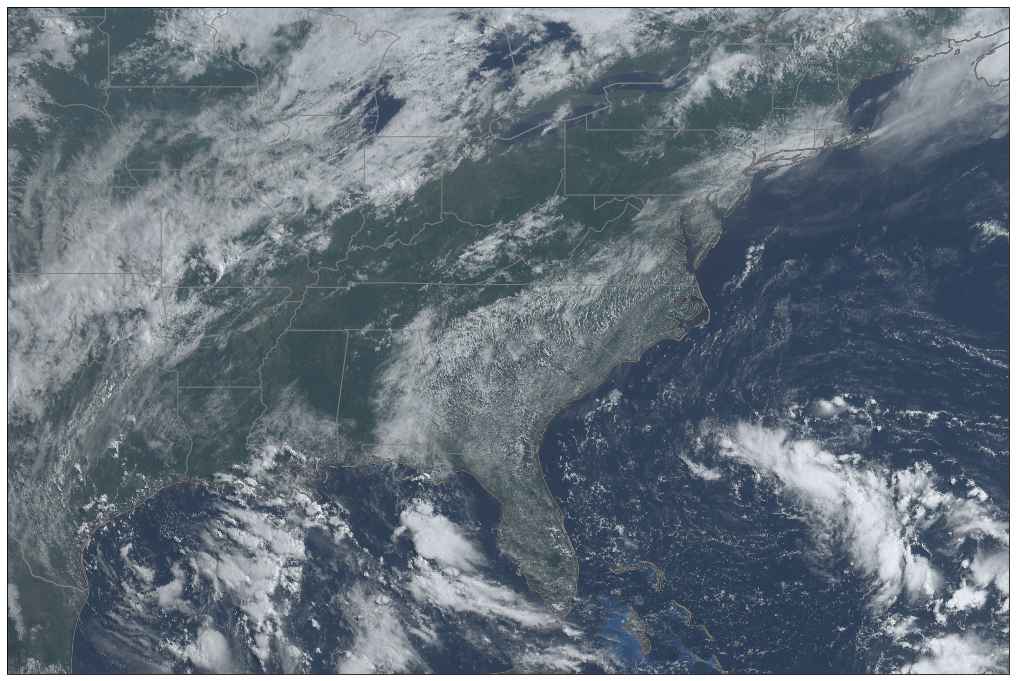

In [89]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


#in_rgb = np.array([goes_R[min_y:max_y, min_x:max_x], goes_G[min_y:max_y, min_x:max_x], goes_B[min_y:max_y, min_x:max_x]])
rgb_arr = np.array([goes_R[min_y:max_y, min_x:max_x].flatten('F'), goes_G_true[min_y:max_y, min_x:max_x].flatten('F'), goes_B[min_y:max_y, min_x:max_x].flatten('F'),
                   np.ones(np.shape(goes_R[min_y:max_y, min_x:max_x].flatten("F")))]).transpose()
#rgb_arr = np.swapaxes(rgb_arr.reshape((goes_R[min_y:max_y, min_x:max_x].shape[0],
#                                       goes_R[min_y:max_y, min_x:max_x].shape[1],4)),0,1).reshape((goes_R[min_y:max_y, min_x:max_x].shape[1]*goes_R[min_y:max_y, min_x:max_x].shape[0],4))
rgb_arr = rgb_arr.reshape((goes_R[min_y:max_y, min_x:max_x].shape[0],
                                       goes_R[min_y:max_y, min_x:max_x].shape[1],4)).reshape((goes_R[min_y:max_y, min_x:max_x].shape[1]*goes_R[min_y:max_y, min_x:max_x].shape[0],4))

f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, goes_G_true[min_y:max_y, min_x:max_x].T, color=rgb_arr)
#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
#f1_goes_1.scatter([70],[0],)
f1_goes_1.set_extent([-100, -65, 23, 45])

In [ ]:
seg_data.sel(time='2021-06-27T14:02', method='nearest')

In [29]:
seg_data_time['segmentation_mask']

<xarray.DataArray 'segmentation_mask' (dim1: 1500, dim2: 2500)>
[3750000 values with dtype=int32]
Coordinates:
    time     datetime64[ns] 2021-06-27T14:02:36.057403
    lat      (dim1, dim2) float32 ...
    lon      (dim1, dim2) float32 ...
Dimensions without coordinates: dim1, dim2
Attributes:
    long_name:  segmentation_mask
    units:      1

In [57]:
np.unique(seg_data_time['segmentation_mask'])

array([    0, 79698, 79706, 79727, 79747, 79759, 79806, 79869, 79890,
       79949], dtype=int32)

/home/sfreeman/anaconda3/envs/tobac_dev/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: UserWarning: Discarding nonzero nanoseconds in conversion
  exec(code_obj, self.user_global_ns, self.user_ns)


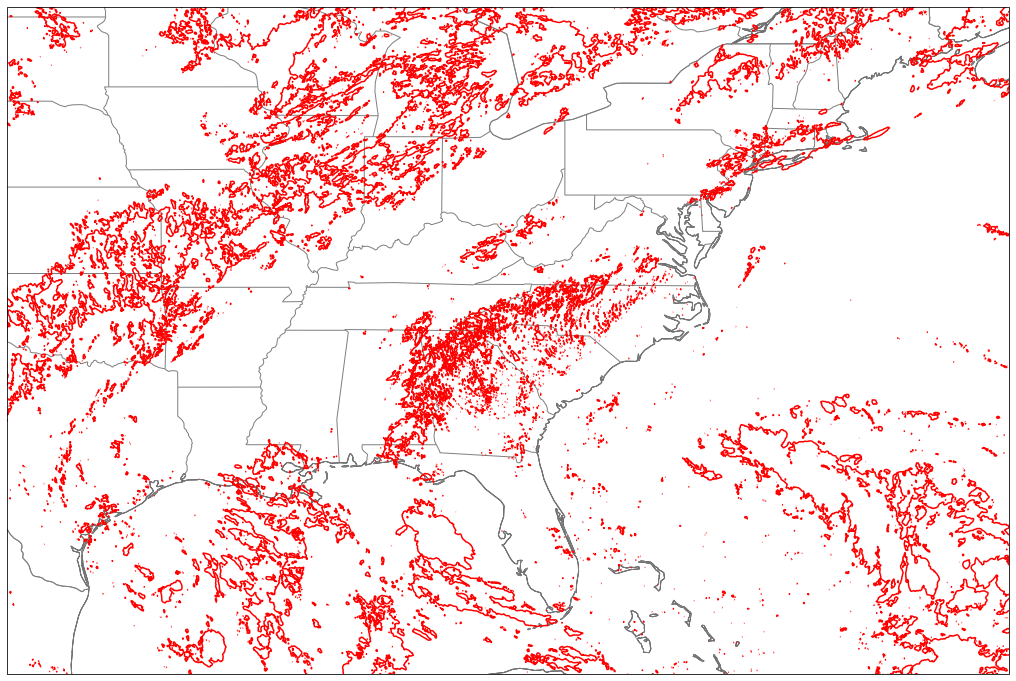

In [75]:
#make the figure
curr_goes_time = pd.to_datetime(in_goes_test_2['time_bounds'].mean().values).to_pydatetime().replace(microsecond=0)
seg_data_time = seg_data.sel(time=curr_goes_time, method='nearest')
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


#cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, in_goes_test_2['CMI_C10'][min_y:max_y, min_x:max_x].T)
#plt.colorbar(cmesh)
f1_goes_1.contour(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, 
                  goes_R[min_y:max_y, min_x:max_x].T, colors='r', levels=[0.6,])
#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
#f1_goes_1.scatter([70],[0],)
f1_goes_1.set_extent([-100, -65, 23, 45])

In [44]:
rgb_arr = np.array([goes_R.flatten('F'), goes_G.flatten('F'), goes_B.flatten('F'),
                   np.ones(np.shape(goes_R.flatten("F")))]).transpose()
rgb_arr = np.swapaxes(rgb_arr.reshape((goes_R.shape[0],goes_R.shape[1],4)),0,1).reshape((goes_R.shape[0]*goes_R.shape[1],4))

In [42]:
truecolor = np.stack([goes_R, goes_G, goes_B], axis=2)
truecolor.shape


(1500, 2500, 3)

In [38]:
np.array([goes_R[min_y:max_y, min_x:max_x], goes_G[min_y:max_y, min_x:max_x], goes_B[min_y:max_y, min_x:max_x]]).shape

(3, 1000, 700)

In [30]:
min_x = 0
min_y = 1100
max_x = 1200
max_y = 1200

llats[min_y:max_y, min_x:max_x][::-1, ::-1]

array([[20.510178, 20.51047 , 20.510715, ..., 21.275612, 21.276861,
        21.278008],
       [20.530432, 20.53068 , 20.530914, ..., 21.29678 , 21.29804 ,
        21.299171],
       [20.55056 , 20.550806, 20.55104 , ..., 21.318087, 21.319223,
        21.320396],
       ...,
       [22.486532, 22.486883, 22.487165, ..., 23.361494, 23.362816,
        23.364141],
       [22.507084, 22.507462, 22.507727, ..., 23.383245, 23.384491,
        23.385813],
       [22.527822, 22.528118, 22.528406, ..., 23.405035, 23.40648 ,
        23.407804]], dtype=float32)

In [14]:
in_goes_test['CMI'].values

array([[      nan,       nan,       nan, ..., 244.49881, 244.89793,
        244.89793],
       [      nan,       nan,       nan, ..., 244.34915, 244.49881,
        244.5487 ],
       [      nan,       nan,       nan, ..., 244.74826, 244.89793,
        244.79816],
       ...,
       [256.32257, 256.02322, 254.87576, ..., 257.47003, 258.21835,
        257.0709 ],
       [256.22278, 256.07312, 255.42455, ..., 256.27267, 258.1186 ,
        257.66956],
       [256.123  , 256.02322, 255.82367, ..., 256.82147, 257.021  ,
        258.368  ]], dtype=float32)

In [83]:
np.min(in_cmi_data[min_y:max_y, min_x:max_x])

0.0063492004

In [95]:
in_glm_test

<xarray.Dataset>
Dimensions:                                 (number_of_events: 3214, number_of_groups: 1142, number_of_flashes: 54, number_of_time_bounds: 2, number_of_wavelength_bounds: 2, number_of_field_of_view_bounds: 2)
Coordinates: (12/21)
    event_id                                (number_of_events) uint32 ...
    event_time_offset                       (number_of_events) datetime64[ns] ...
    event_lat                               (number_of_events) float32 ...
    event_lon                               (number_of_events) float32 ...
    event_parent_group_id                   (number_of_events) uint32 ...
    group_id                                (number_of_groups) uint32 ...
    ...                                      ...
    product_time                            datetime64[ns] ...
    lightning_wavelength                    float32 ...
    group_time_threshold                    float32 ...
    flash_time_threshold                    float32 ...
    lat_field_of_view                       float32 ...
    lon_field_of_view                       float32 ...
Dimensions without coordinates: number_of_events, number_of_groups, number_of_flashes, number_of_time_bounds, number_of_wavelength_bounds, number_of_field_of_view_bounds
Data variables: (12/27)
    event_energy                            (number_of_events) float32 ...
    group_frame_time_offset                 (number_of_groups) datetime64[ns] ...
    group_area                              (number_of_groups) float32 ...
    group_energy                            (number_of_groups) float32 ...
    group_quality_flag                      (number_of_groups) float32 ...
    flash_frame_time_offset_of_first_event  (number_of_flashes) datetime64[ns] ...
    ...                                      ...
    nominal_satellite_subpoint_lon          float32 ...
    lon_field_of_view_bounds                (number_of_field_of_view_bounds) float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    algorithm_dynamic_input_data_container  int32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    production_site:           WCDAS
    featureType:               point
    dataset_name:              OR_GLM-L2-LCFA_G16_s20211781401000_e2021178140...
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    institution:               DOC/NOAA/NESDIS> U.S. Department of Commerce, ...
    ...                        ...
    time_coverage_start:       2021-06-27T14:01:00.0Z
    time_coverage_end:         2021-06-27T14:01:20.0Z
    production_data_source:    Realtime
    production_environment:    OE
    LUT_Filenames:             GLM_CALINR_AllFilters(FM1E_CDRL79RevK_PR_09_00...
    id:                        ce8f28f9-f639-4aba-b8b3-66c9f5b9b01d

In [97]:
glm_gridded = xr.open_dataset("./test_goes_file/OR_GLM-L2-GLMC-M3_G16_s20213211434000_e20213211435000_c20213211435290.nc")

In [98]:
glm_gridded

<xarray.Dataset>
Dimensions:                         (x: 2500, y: 1500, dim_0: 1)
Coordinates:
  * x                               (x) float32 -0.1013 -0.1013 ... 0.03861
  * y                               (y) float32 0.1282 0.1282 ... 0.04427
Dimensions without coordinates: dim_0
Data variables:
    goes_imager_projection          int32 ...
    DQF                             (y, x) float32 ...
    nominal_satellite_subpoint_lat  float64 ...
    nominal_satellite_subpoint_lon  (dim_0) float64 ...
    flash_extent_density            (y, x) float32 ...
    flash_centroid_density          (y, x) float32 ...
    average_flash_area              (y, x) float32 ...
    total_energy                    (y, x) float32 ...
    group_extent_density            (y, x) float32 ...
    group_centroid_density          (y, x) float32 ...
    average_group_area              (y, x) float32 ...
    minimum_flash_area              (y, x) float32 ...
Attributes: (12/29)
    cdm_data_type:             Image
    Conventions:               CF-1.7
    id:                        93cb84a3-31ef-4823-89f5-c09d88fc89e8
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    instrument_type:           GOES R Series Geostationary Lightning Mapper
    iso_series_metadata_id:    f5816f53-fd6d-11e3-a3ac-0800200c9a66
    ...                        ...
    production_site:           TTU
    scene_id:                  CONUS
    spatial_resolution:        2km at nadir
    time_coverage_end:         2021-11-17T14:35:00Z
    time_coverage_start:       2021-11-17T14:34:00Z
    timeline_id:               ABI Mode 3

/home/sfreeman/anaconda3/envs/tobac_dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


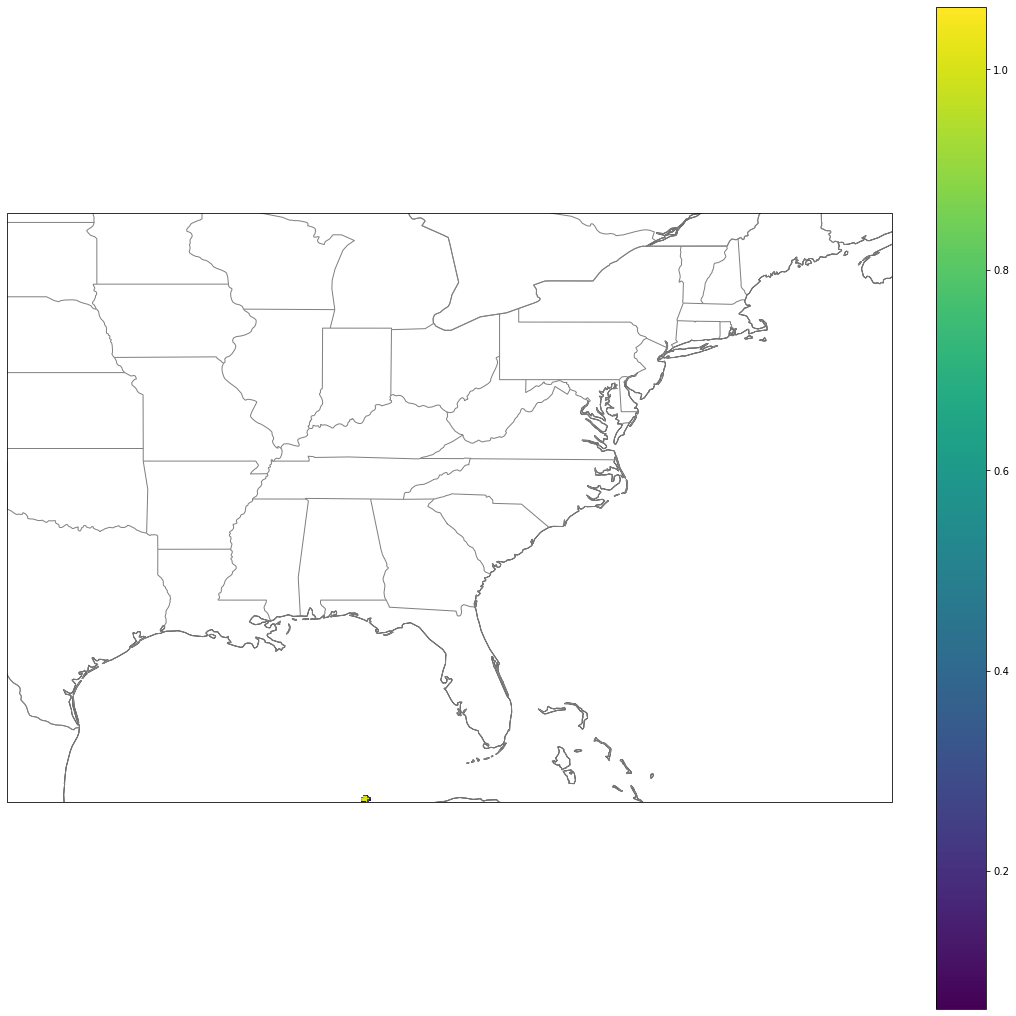

In [99]:
#make the figure
fig1 = plt.figure(figsize = (14,14), constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, figure=fig1)

f1_goes_1 = fig1.add_subplot(spec1[0, 0], projection=proj)
#f1_goes_1.gridlines(xlocs=xticks, ylocs=yticks, linestyle=':', zorder=3)
# Label the end-points of the gridlines using the custom tick makers:
#f1_goes_1.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
#f1_goes_1.yaxis.set_major_formatter(LATITUDE_FORMATTER)
f1_goes_1.coastlines(resolution='50m')
#f1_goes_1.borders(resolution='50m')
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')

f1_goes_1.add_feature(states_provinces, edgecolor='gray')
f1_goes_1.add_feature(country_borders, edgecolor='gray')

#this works for squares onlu, figure out non-squares.
min_x = 400
min_y = 100
max_x = 2500
max_y = 1100


cmesh = f1_goes_1.pcolormesh(goes_proj_x[min_y:max_y, min_x:max_x].T, goes_proj_y[min_y:max_y, min_x:max_x].T, glm_gridded['flash_extent_density'][min_y:max_y, min_x:max_x].T)
plt.colorbar(cmesh)
#f1_goes_1.scatter(goes_proj_x[min_y:max_y, min_x:max_x], goes_proj_y[min_y:max_y, min_x:max_x], )
#f1_goes_1.scatter([70],[0],)
f1_goes_1.set_extent([-100, -65, 23, 45])